In [1]:
import numpy as np; import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
font = {'family' : 'DejaVu Sans',
        'size'   : fs}
mpl.rc('font', **font)

In [2]:
# Read measured c_tot and c_EMC 
# for HP: C:/Users/rl1120/OneDrive - Imperial College London/SimDataSave/InputData/
# for 411 PC: 'D:/OneDrive - Imperial College London/SimDataSave/P3R13/'; 
Path_c_tot = 'C:/Users/rl1120/OneDrive - Imperial College London/SimDataSave/InputData/'; 
df=pd.read_csv(Path_c_tot+"c_tot_c_back.csv",) 
df.head()

,ec,Temp,xLiPF6,c_LiPF6 - mol/m3,xEC,c_EC - mol/m3,xEMC,c_EMC - mol/m3,d-g/cm3,v,k-mS/cm,k-S/m,n between EC and Li+,c_tot
0,0.0,25,0.00000,0.000000,0.0,0.0,1.00000,9664.374087,1.0061,0.69,0.00,0.000,NaN,9664.374087
1,0.0,25,0.01394,93.392173,0.0,0.0,0.98606,9639.526454,1.0177,0.73,0.06,0.006,0,9826.310799
2,0.0,25,0.07384,518.855969,0.0,0.0,0.92616,9496.111427,1.0674,1.07,1.59,0.159,0,10533.823370
3,0.0,25,0.13444,989.105981,0.0,0.0,0.86556,9292.148774,1.1176,1.78,4.66,0.466,0,11270.360740
4,0.0,25,0.19654,1512.622455,0.0,0.0,0.80346,9022.949032,1.1691,3.34,6.46,0.646,0,12048.193940


R2 for c_EMC: 0.999708423900735
RMSE for c_EMC: 37.76840149438037
R2 for c_tot: 0.9994536998502743
RMSE for c_tot: 37.768401467753556


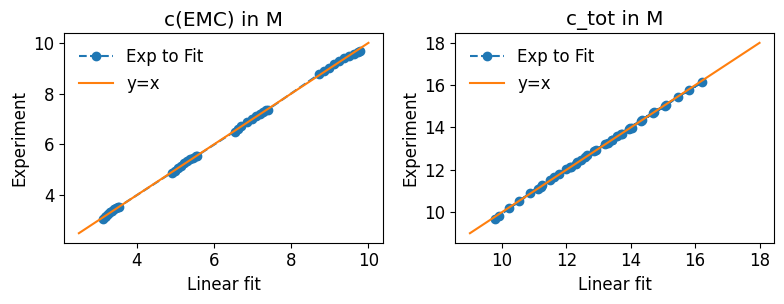

In [65]:
# important function for c_EMC and c_tot - get from MATLAB cftool
c_e_exp, c_EC_exp = np.meshgrid(df["c_LiPF6 - mol/m3"], df["c_EC - mol/m3"])
def Fun_c_EMC(c_e, c_EC):
    c_emc = 9778-0.5369*c_e-0.6411*c_EC
    c_emc_out = (c_emc>0) * c_emc + (c_emc<=0) *0
    return c_emc_out
def Fun_c_tot(c_e, c_EC):
    c_emc = 9778-0.5369*c_e-0.6411*c_EC
    c_emc_out = (c_emc>0) * c_emc + (c_emc<=0) *0
    c_tot = c_emc_out + 2*c_e + c_EC
    return c_tot
c_EC_exp = df["c_EC - mol/m3"].to_numpy()
c_e_exp = df["c_LiPF6 - mol/m3"].to_numpy()
c_tot_Fit = [];  c_EMC_Fit = [];
for c_e_i,c_EC_i in zip(c_e_exp,c_EC_exp):
    c_tot_Fit.append(Fun_c_tot(c_e_i,c_EC_i))
    c_EMC_Fit.append(Fun_c_EMC(c_e_i,c_EC_i))
c_EMC_Fit= np.array(c_EMC_Fit);    c_tot_Fit = np.array(c_tot_Fit);
c_EMC_exp = df["c_EMC - mol/m3"].to_numpy(); c_tot_exp = df["c_tot"].to_numpy()
# evaluate fit result
import sklearn.metrics as skmetrics

print(f'R2 for c_EMC: {skmetrics.r2_score(c_EMC_Fit, c_EMC_exp)}')
print(f'RMSE for c_EMC: {np.sqrt(skmetrics.mean_squared_error(c_EMC_Fit, c_EMC_exp))}')
print(f'R2 for c_tot: {skmetrics.r2_score(c_tot_Fit, c_tot_exp)}')
print(f'RMSE for c_tot: {np.sqrt(skmetrics.mean_squared_error(c_tot_Fit, c_tot_exp))}')
Path_taeho = 'C:/Users/rl1120/OneDrive - Imperial College London/SimDataSave/InputData/Taeho/'; 
fig, axs = plt.subplots(1,2, figsize=(8,3.2),tight_layout=True)
axs[0].plot(c_EMC_Fit/1e3, c_EMC_exp/1e3,"--o",label="Exp to Fit")
axs[0].plot(np.linspace(2.500,10,100), np.linspace(2.500,10,100),"-",label="y=x")
axs[1].plot(c_tot_Fit/1e3, c_tot_exp/1e3,"--o",label="Exp to Fit")
axs[1].plot(np.linspace(9,18,100), np.linspace(9,18,100),"-",label="y=x")
for i in range(2): 
    axs[i].set_xlabel("Linear fit")
    axs[i].set_ylabel("Experiment")
    axs[i].legend(loc='best',frameon=False)  
axs[0].set_title("c(EMC) in M")
axs[1].set_title("c_tot in M")
plt.savefig(Path_taeho+"Fit_c_EMC and c_tot.png", dpi=600)

In [66]:
# One species - np version:
def LJP_1Species_np(ye,T):   # ALL IN ISO Units
    # Eq. (13):
    R = 8.31446261815324
    F = 96485.3321
    aln = 1.390; a0 = 1.158; a1 = -8.955; a2 = 164.7
    delta_U = R*T/F*(
        aln * np.log(ye) + a0 + a1*ye  + a2 * ye**2
    )
    return delta_U
# Try to define Taeho's pre-print liquid junction potential Eq. (17), which contains (14),(18),(19)
def LJP_Two_Species_np(yo,ye):
    T = 298.15;
    # y0 = c0/cT;   ye = ce/cT;
    # constant first
    R = 8.31446261815324; F = 96485.3321
    bln = 3.024; b0 = 8.233; b1 = -88.12; b2 = 477.9;
    p = 32.2;     q = -37.99;   r = -44.80
    # Eq. (14):
    delta_U_1to0 = R*T/F*(
        7.167 - 43.16*ye**0.5 + 185.4*ye - 402.4*ye**1.5 
        + 236.9*ye**2 + 253.7*ye**2.5 - 408.1*ye**3 
        + 2509*ye**3.5 - 2886*ye**4.5 + 1.174*np.log(ye) 
    )
    # Eq. (18):
    delta_U_0to1 = R*T/F*(
        bln*np.log(ye) + b0 + b1*ye + b2*ye**2
    )
    # Eq. (19):
    delta_U_ex = R*T/F*  yo  * (
        (1-yo-2*ye) * (
        p + q*yo + r*(1-yo-2*ye)
        )
    )
    delta_U = (
        ( 1 - yo/(1-2*ye)  ) * delta_U_1to0 
        + yo/(1-2*ye) * delta_U_0to1 
        + delta_U_ex
    )
    return delta_U # units: V

Text(0.5, 0, 'ye')

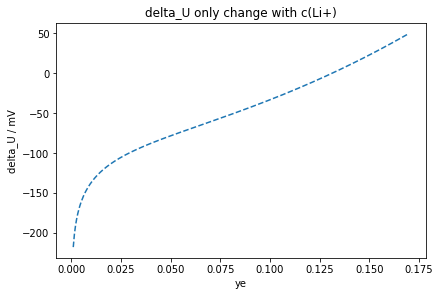

In [5]:
# plot delta_U as one species
fs=12
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
Y_e = np.linspace(1E-3,0.17,300).tolist(); T=298.75
delta_U_1Species_1 = []; delta_U_1Species_2 = []; 
for ye in Y_e:
    delta_U_1Species_2.append(LJP_1Species_np(ye,T))
fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
ax.plot(Y_e,np.array(delta_U_1Species_2)*1e3,'--')
ax.set_ylabel("delta_U / V")
ax.set_title("delta_U only change with c(Li+)")
ax.set_xlabel("ye")

In [55]:
# Try to define Taeho's pre-print liquid junction potential Eq. (17), which contains (14),(18),(19)
import sympy as sy
def LJP_Two_Species_sy(ce,co):
    T = 298.15;
    c_emc = 9778-0.5369*ce-0.6411*co
    c_emc_out = c_emc  # (c_emc>0) * c_emc + (c_emc<=0) *0
    c_tot = c_emc_out + 2*ce + co
    yo = co/c_tot;   ye = ce/c_tot;
    # constant first
    R = 8.31446261815324; F = 96485.3321
    bln = 3.024; b0 = 8.233; b1 = -88.12; b2 = 477.9;
    p = 32.2;     q = -37.99;   r = -44.80
    # Eq. (14):
    delta_U_1to0 = R*T/F*(
        7.167 - 43.16*ye**0.5 + 185.4*ye - 402.4*ye**1.5 
        + 236.9*ye**2 + 253.7*ye**2.5 - 408.1*ye**3 
        + 2509*ye**3.5 - 2886*ye**4.5 + 1.174*sy.log(ye) 
    )
    # Eq. (18):
    delta_U_0to1 = R*T/F*(
        bln*sy.log(ye) 
        + b0 + b1*ye + b2*ye**2
    )
    # Eq. (19):
    delta_U_ex = R*T/F*  yo  * (
        (1-yo-2*ye) * (
        p + q*yo + r*(1-yo-2*ye)
        )
    )
    delta_U = (
        ( 1 - yo/(1-2*ye)  ) * delta_U_1to0 
        + yo/(1-2*ye) * delta_U_0to1 
        + delta_U_ex
    )
    return delta_U # units: V

In [46]:
from sympy import symbols,diff
x,y=symbols("x y",real=True)
dLJP_Two_Species_dco_r = diff(LJP_Two_Species_sy(x,y),y) # x: ce; y: co
dLJP_Two_Species_dce_r = diff(LJP_Two_Species_sy(x,y),x)

In [109]:
# manually copy from diff result: 
# ~~~~# x: ce; y: co
def Fun_dLJP_Two_Species_dco_sys_Manual(x,y):
    dLJP_dco = (
        -7.50763911169966e-9*x*y
        *(
            1.28423548961347e-7*x**2
            /(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 
            - 2.26403007269705*x/(1.4631*x + 0.3589*y + 9778) 
            + 0.0776943592809339*np.log(x/(1.4631*x + 0.3589*y + 9778)) + 0.211527003955003
        )
        /(
            (-2*x/(1.4631*x + 0.3589*y + 9778) + 1)**2
            *(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2
            *(1.4631*x + 0.3589*y + 9778)
        ) 
        + 0.0256925791272929*y
        *(
            -3.36342232204145e-7*x
            /(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 
            - 2.55635111753373e-8*y/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 
            + 6.81/(1.4631*x + 0.3589*y + 9778))
        *(-2*x/(1.4631*x + 0.3589*y + 9778) - y/(1.4631*x + 0.3589*y + 9778) + 1)/(1.4631*x + 0.3589*y + 9778) 
        + 0.0256925791272929*y*(
            7.50763911169966e-9*x/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 
            + 3.75381955584983e-9*y/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 
            - 1/(1.4631*x + 0.3589*y + 9778))
        *(89.6*x/(1.4631*x + 0.3589*y + 9778) + 6.81*y/(1.4631*x + 0.3589*y + 9778) - 12.6)
        /(1.4631*x + 0.3589*y + 9778) 
        - 9.64453059682514e-11*y*(-2*x/(1.4631*x + 0.3589*y + 9778) - y/(1.4631*x + 0.3589*y + 9778) + 1)
        *(89.6*x/(1.4631*x + 0.3589*y + 9778) + 6.81*y/(1.4631*x + 0.3589*y + 9778) - 12.6)
        /(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 
        + y*(
            -9.42753359014672e-12*x**2/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**3 
            + 8.49876036192231e-9*x/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 
            - 2.91650605247992e-10*(1.4631*x + 0.3589*y + 9778)/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2)
        /((-2*x/(1.4631*x + 0.3589*y + 9778) + 1)*(1.4631*x + 0.3589*y + 9778)) 
        - 3.75381955584983e-9*y*(
            1.28423548961347e-7*x**2/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 
            - 2.26403007269705*x/(1.4631*x + 0.3589*y + 9778) 
            + 0.0776943592809339*np.log(x/(1.4631*x + 0.3589*y + 9778)) + 0.211527003955003)
        /((-2*x/(1.4631*x + 0.3589*y + 9778) + 1)*(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2) 
        + (-y/((-2*x/(1.4631*x + 0.3589*y + 9778) + 1)*(1.4631*x + 0.3589*y + 9778)) + 1)
        *(
            1.23500546345405e-15*x**3/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**4 
            - 4.67332644382875e-12*x**2/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**3 
            - 1.78809597265138e-8*x/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 
            + 2.08128970279486e-9*(x/(1.4631*x + 0.3589*y + 9778))**0.5*(1.4631*x + 0.3589*y + 9778)/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 
            + 5.82143866824365e-8*(x/(1.4631*x + 0.3589*y + 9778))**1.5*(1.4631*x + 0.3589*y + 9778)/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 
            - 6.11704353103634e-8*(x/(1.4631*x + 0.3589*y + 9778))**2.5*(1.4631*x + 0.3589*y + 9778)/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 
            - 8.46934454360199e-7*(x/(1.4631*x + 0.3589*y + 9778))**3.5*(1.4631*x + 0.3589*y + 9778)/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 
            + 1.25253518860968e-6*(x/(1.4631*x + 0.3589*y + 9778))**4.5*(1.4631*x + 0.3589*y + 9778)/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 
            - 1.13226789206727e-10*(1.4631*x + 0.3589*y + 9778)/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2) 
        + (
            7.50763911169966e-9*x*y/((-2*x/(1.4631*x + 0.3589*y + 9778) + 1)**2*(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2*(1.4631*x + 0.3589*y + 9778)) 
            + 3.75381955584983e-9*y/((-2*x/(1.4631*x + 0.3589*y + 9778) + 1)*(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2) - 1/((-2*x/(1.4631*x + 0.3589*y + 9778) + 1)
            *(1.4631*x + 0.3589*y + 9778))
        )
        *(-1.12156435605589e-11*x**3/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**3 
        + 6.36608887820528e-8*x**2/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 + 4.76340417020011*x
        /(1.4631*x + 0.3589*y + 9778) 
        - 1.10889171513396*(x/(1.4631*x + 0.3589*y + 9778))**0.5 - 10.3386938408227*(x/(1.4631*x + 0.3589*y + 9778))**1.5 
        + 6.51820732459422*(x/(1.4631*x + 0.3589*y + 9778))**2.5 + 64.462681030378*(x/(1.4631*x + 0.3589*y + 9778))**3.5 
        - 74.1487833613674*(x/(1.4631*x + 0.3589*y + 9778))**4.5 + 0.0301630878954419*np.log(x/(1.4631*x + 0.3589*y + 9778)) 
        + 0.184138714605309) 
        + 0.0256925791272929*(-2*x/(1.4631*x + 0.3589*y + 9778) - y/(1.4631*x + 0.3589*y + 9778) + 1)*(89.6*x/(1.4631*x + 0.3589*y + 9778) 
        + 6.81*y/(1.4631*x + 0.3589*y + 9778) - 12.6)/(1.4631*x + 0.3589*y + 9778) + (1.28423548961347e-7*x**2/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 
        - 2.26403007269705*x/(1.4631*x + 0.3589*y + 9778) + 0.0776943592809339*np.log(x/(1.4631*x + 0.3589*y + 9778)) + 0.211527003955003)
        /((-2*x/(1.4631*x + 0.3589*y + 9778) + 1)*(1.4631*x + 0.3589*y + 9778))
    )
    return dLJP_dco
def Fun_dLJP_Two_Species_dce_sys_Manual(x,y):
    dLJP_dce = (
        y*(-3.06058143893223e-8*x/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 + 2/(1.4631*x + 0.3589*y + 9778))
        *(1.28423548961347e-7*x**2/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 - 2.26403007269705*x/(1.4631*x + 0.3589*y + 9778) + 0.0776943592809339*np.log(x/(1.4631*x + 0.3589*y + 9778)) + 0.211527003955003)/((-2*x/(1.4631*x + 0.3589*y + 9778) + 1)**2*(1.4631*x + 0.3589*y + 9778)) + 0.0256925791272929*y*(-1.37114048464164e-6*x/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 - 1.04212797995642e-7*y/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 + 89.6/(1.4631*x + 0.3589*y + 9778))*(-2*x/(1.4631*x + 0.3589*y + 9778) - y/(1.4631*x + 0.3589*y + 9778) + 1)/(1.4631*x + 0.3589*y + 9778) + 0.0256925791272929*y*(3.06058143893223e-8*x/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 + 1.53029071946611e-8*y/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 - 2/(1.4631*x + 0.3589*y + 9778))*(89.6*x/(1.4631*x + 0.3589*y + 9778) + 6.81*y/(1.4631*x + 0.3589*y + 9778) - 12.6)/(1.4631*x + 0.3589*y + 9778) - 3.93171153976452e-10*y*(-2*x/(1.4631*x + 0.3589*y + 9778) - y/(1.4631*x + 0.3589*y + 9778) + 1)*(89.6*x/(1.4631*x + 0.3589*y + 9778) + 6.81*y/(1.4631*x + 0.3589*y + 9778) - 12.6)/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 + y*(-3.84325004060843e-11*x**2/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**3 + 2.91493340011098e-7*x/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 - 2.26403007269705/(1.4631*x + 0.3589*y + 9778) + 0.0776943592809339*(-1.53029071946611e-8*x/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 + 1/(1.4631*x + 0.3589*y + 9778))*(1.4631*x + 0.3589*y + 9778)/x)/((-2*x/(1.4631*x + 0.3589*y + 9778) + 1)*(1.4631*x + 0.3589*y + 9778)) - 1.53029071946611e-8*y*(1.28423548961347e-7*x**2/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 - 2.26403007269705*x/(1.4631*x + 0.3589*y + 9778) + 0.0776943592809339*np.log(x/(1.4631*x + 0.3589*y + 9778)) + 0.211527003955003)/((-2*x/(1.4631*x + 0.3589*y + 9778) + 1)*(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2) + (-y/((-2*x/(1.4631*x + 0.3589*y + 9778) + 1)*(1.4631*x + 0.3589*y + 9778)) + 1)*(5.0346516956802e-15*x**3/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**4 - 5.26983208181097e-11*x**2/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**3 + 5.44278456168714e-8*x/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 + 4.76340417020011/(1.4631*x + 0.3589*y + 9778) - 1.10889171513396*(x/(1.4631*x + 0.3589*y + 9778))**0.5*(-7.65145359733057e-9*x/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 + 0.5/(1.4631*x + 0.3589*y + 9778))*(1.4631*x + 0.3589*y + 9778)/x - 10.3386938408227*(x/(1.4631*x + 0.3589*y + 9778))**1.5*(-2.29543607919917e-8*x/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 + 1.5/(1.4631*x + 0.3589*y + 9778))*(1.4631*x + 0.3589*y + 9778)/x + 6.51820732459422*(x/(1.4631*x + 0.3589*y + 9778))**2.5*(-3.82572679866528e-8*x/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 + 2.5/(1.4631*x + 0.3589*y + 9778))*(1.4631*x + 0.3589*y + 9778)/x + 64.462681030378*(x/(1.4631*x + 0.3589*y + 9778))**3.5*(-5.3560175181314e-8*x/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 + 3.5/(1.4631*x + 0.3589*y + 9778))*(1.4631*x + 0.3589*y + 9778)/x - 74.1487833613674*(x/(1.4631*x + 0.3589*y + 9778))**4.5*(-6.88630823759751e-8*x/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 + 4.5/(1.4631*x + 0.3589*y + 9778))*(1.4631*x + 0.3589*y + 9778)/x + 0.0301630878954419*(-1.53029071946611e-8*x/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 + 1/(1.4631*x + 0.3589*y + 9778))*(1.4631*x + 0.3589*y + 9778)/x) + (-y*(-3.06058143893223e-8*x/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 + 2/(1.4631*x + 0.3589*y + 9778))/((-2*x/(1.4631*x + 0.3589*y + 9778) + 1)**2*(1.4631*x + 0.3589*y + 9778)) + 1.53029071946611e-8*y/((-2*x/(1.4631*x + 0.3589*y + 9778) + 1)*(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2))*(-1.12156435605589e-11*x**3/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**3 + 6.36608887820528e-8*x**2/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 + 4.76340417020011*x/(1.4631*x + 0.3589*y + 9778) - 1.10889171513396*(x/(1.4631*x + 0.3589*y + 9778))**0.5 - 10.3386938408227*(x/(1.4631*x + 0.3589*y + 9778))**1.5 + 6.51820732459422*(x/(1.4631*x + 0.3589*y + 9778))**2.5 + 64.462681030378*(x/(1.4631*x + 0.3589*y + 9778))**3.5 - 74.1487833613674*(x/(1.4631*x + 0.3589*y + 9778))**4.5 + 0.0301630878954419*np.log(x/(1.4631*x + 0.3589*y + 9778)) + 0.184138714605309)
    )
    return dLJP_dce

In [108]:
print(dLJP_Two_Species_dce_r)

y*(-3.06058143893223e-8*x/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 + 2/(1.4631*x + 0.3589*y + 9778))*(1.28423548961347e-7*x**2/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 - 2.26403007269705*x/(1.4631*x + 0.3589*y + 9778) + 0.0776943592809339*log(x/(1.4631*x + 0.3589*y + 9778)) + 0.211527003955003)/((-2*x/(1.4631*x + 0.3589*y + 9778) + 1)**2*(1.4631*x + 0.3589*y + 9778)) + 0.0256925791272929*y*(-1.37114048464164e-6*x/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 - 1.04212797995642e-7*y/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 + 89.6/(1.4631*x + 0.3589*y + 9778))*(-2*x/(1.4631*x + 0.3589*y + 9778) - y/(1.4631*x + 0.3589*y + 9778) + 1)/(1.4631*x + 0.3589*y + 9778) + 0.0256925791272929*y*(3.06058143893223e-8*x/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 + 1.53029071946611e-8*y/(0.000149631826549397*x + 3.67048476170996e-5*y + 1)**2 - 2/(1.4631*x + 0.3589*y + 9778))*(89.6*x/(1.4631*x + 0.3589*y + 9778) + 6.81*y/(1.4631*x + 0.35

In [98]:
# Now based on that, define something I need for my model:
def dLJP_One_Specie_dce_Jung2023(ce,co): # co means c_EC here
    # Eq. (13):
    R = 8.31446261815324;  F = 96485.3321
    c_tot = 1.379*ce+1.113e4
    aln = 1.390; a0 = 1.158; a1 = -8.955; a2 = 164.7
    ddelta_U_dce = R*T/F*(
        aln / ce  + a1/c_tot  + 2*a2*ce/c_tot**2
    )
    return ddelta_U_dce

def dLJP_Two_Species_dco_Jung2023(ce,co,):
    T = 298.15;     # need to be a variable 
    c_emc = 9778-0.5369*ce-0.6411*co
    c_emc_out = c_emc  # (c_emc>0) * c_emc + (c_emc<=0) *0
    c_tot = c_emc_out + 2*ce + co # also:  k0+ke*ce+ko*co
    yo = co/c_tot;   ye = ce/c_tot;
    # constant first
    R = 8.31446261815324; F = 96485.3321
    bln = 3.024; b0 = 8.233; b1 = -88.12; b2 = 477.9;
    p = 32.2;     q = -37.99;   r = -44.80;
    k0=9778; ke=1.4631; ko=0.3589;

    # Eq.(P-1) 
    Pre_fac_1 = 1-yo/(1-2*ye)   
    # Eq.(P-2) 
    dPre_fac_1_dco = - (k0 + (ke-2)*ce) / (k0+(ke-2)*ce+ko*co)**2
    # Eq.(P-3) 
    dPre_fac_1_dce =  (ke-2)*co / (   k0+(ke-2)*ce+ko*co  )**2
    # Eq.(P-4)
    Pre_fac_2 = yo/(1-2*ye)
    # Eq.(P-5)
    dPre_fac_2_dco = - dPre_fac_1_dco
    # Eq.(P-6)
    dPre_fac_2_dce = - dPre_fac_1_dce

    # Eq. (14):
    delta_U_1to0 = R*T/F*(
        7.167 - 43.16*ye**0.5 + 185.4*ye - 402.4*ye**1.5 
        + 236.9*ye**2 + 253.7*ye**2.5 - 408.1*ye**3 
        + 2509*ye**3.5 - 2886*ye**4.5 + 1.174*np.log(ye) 
    )
    # Eq. (18):
    delta_U_0to1 = R*T/F*(
        bln*np.log(ye) + b0 + b1*ye + b2*ye**2
    )
    # Eq. (23-1):
    ddelta_U_ex_dyo = R*T/F * (
        (1-2*yo-2*ye) * (p+q*yo+r*(1-yo-2*ye))
        +
        (yo-yo**2-2*ye*yo) * (q-r)
    )
    # Eq. (23-2):
    ddelta_U_ex_dye = R*T/F * (
        -2*yo * (p+q*yo+r*(1-yo-2*ye))   
        +
        (yo-yo**2-2*ye*yo) * (-2*r)
    )
    # Eq. (23-3) and (23-4):
    dyo_dco = (k0+ke*ce) / (k0+ke*ce+ko*co)**2
    dye_dco = -ko*ce / (k0+ke*ce+ko*co)**2
    # Eq. (23)
    ddelta_U_ex_dco = (
        ddelta_U_ex_dyo * dyo_dco
        + ddelta_U_ex_dye * dye_dco )
    # Eq. (24-1) and (24-2):
    dyo_dce = -ke*co / (k0+ke*ce+ko*co)**2

    dye_dce = (k0+ko*co) / (k0+ke*ce+ko*co)**2
    # Eq. (24)
    ddelta_U_ex_dce = (
        ddelta_U_ex_dyo * dyo_dce 
        + ddelta_U_ex_dye * dye_dce
    )
    # Eq. (F-1):
    dLJP_dco = (
        dPre_fac_1_dco * delta_U_1to0
        + dPre_fac_2_dco * delta_U_0to1
        + ddelta_U_ex_dco
    )
    # Eq. (25-2):
    ddeltaU_1to0_dye = R*T/F*(
        0.5*43.16*ye**(-0.5) + 185.4 - 1.5*402.4*ye**0.5 
        + 2*236.9*ye + 2.5*253.7*ye**1.5 - 3*408.1*ye**2 
        + 3.5*2509*ye**2.5 - 4.5*2886*ye**3.5 + 1.174/ye 
    )
    # Eq. (25):
    ddeltaU_1to0_dce = ddeltaU_1to0_dye * dye_dce
    # Eq. (26-2):
    ddeltaU_0to1_dye = R*T/F*(bln/ye + b1 + 2*b2*ye)
    # Eq. (26):
    ddeltaU_0to1_dce = ddeltaU_0to1_dye * dye_dce
    # Eq. (F-2):
    dLJP_dce = (
        dPre_fac_1_dce * delta_U_1to0
        +
        Pre_fac_1 * ddeltaU_1to0_dce
        +
        dPre_fac_2_dce * delta_U_0to1
        +
        Pre_fac_2 * ddeltaU_0to1_dce
        +
        ddelta_U_ex_dce
    )
    return dLJP_dco   # units: V

def dLJP_Two_Species_dce_Jung2023(ce,co,):
    T = 298.15;     # need to be a variable 
    c_emc = 9778-0.5369*ce-0.6411*co
    c_emc_out = c_emc  # (c_emc>0) * c_emc + (c_emc<=0) *0
    c_tot = c_emc_out + 2*ce + co # also:  k0+ke*ce+ko*co
    yo = co/c_tot;   ye = ce/c_tot;
    # constant first
    R = 8.31446261815324; F = 96485.3321
    bln = 3.024; b0 = 8.233; b1 = -88.12; b2 = 477.9;
    p = 32.2;     q = -37.99;   r = -44.80;
    k0=9778; ke=1.4631; ko=0.3589;

    # Eq.(P-1) 
    Pre_fac_1 = 1-yo/(1-2*ye)   
    # Eq.(P-2) 
    dPre_fac_1_dco = - (k0 + (ke-2)*ce) / (k0+(ke-2)*ce+ko*co)**2
    # Eq.(P-3) 
    dPre_fac_1_dce =  (ke-2)*co / (   k0+(ke-2)*ce+ko*co  )**2
    # Eq.(P-4)
    Pre_fac_2 = yo/(1-2*ye)
    # Eq.(P-5)
    dPre_fac_2_dco = - dPre_fac_1_dco
    # Eq.(P-6)
    dPre_fac_2_dce = - dPre_fac_1_dce

    # Eq. (14):
    delta_U_1to0 = R*T/F*(
        7.167 - 43.16*ye**0.5 + 185.4*ye - 402.4*ye**1.5 
        + 236.9*ye**2 + 253.7*ye**2.5 - 408.1*ye**3 
        + 2509*ye**3.5 - 2886*ye**4.5 + 1.174*np.log(ye) 
    )
    # Eq. (18):
    delta_U_0to1 = R*T/F*(
        bln*np.log(ye) + b0 + b1*ye + b2*ye**2
    )
    # Eq. (23-1):
    ddelta_U_ex_dyo = R*T/F * (
        (1-2*yo-2*ye) * (p+q*yo+r*(1-yo-2*ye))
        +
        (yo-yo**2-2*ye*yo) * (q-r)
    )
    # Eq. (23-2):
    ddelta_U_ex_dye = R*T/F * (
        -2*yo * (p+q*yo+r*(1-yo-2*ye))   
        +
        (yo-yo**2-2*ye*yo) * (-2*r)
    )
    # Eq. (23-3) and (23-4):
    dyo_dco = (k0+ke*ce) / (k0+ke*ce+ko*co)**2
    dye_dco = -ko*ce / (k0+ke*ce+ko*co)**2
    # Eq. (23)
    ddelta_U_ex_dco = (
        ddelta_U_ex_dyo * dyo_dco
        + ddelta_U_ex_dye * dye_dco )
    # Eq. (24-1) and (24-2):
    dyo_dce = -ke*co / (k0+ke*ce+ko*co)**2
    dye_dce = (k0+ko*co) / (k0+ke*ce+ko*co)**2
    # Eq. (24)
    ddelta_U_ex_dce = (
        ddelta_U_ex_dyo * dyo_dce 
        + ddelta_U_ex_dye * dye_dce
    )
    # Eq. (F-1):
    dLJP_dco = (
        dPre_fac_1_dco * delta_U_1to0
        + dPre_fac_2_dco * delta_U_0to1
        + ddelta_U_ex_dco
    )
    # Eq. (25-2):
    ddeltaU_1to0_dye = R*T/F*(
        0.5*43.16*ye**(-0.5) + 185.4 - 1.5*402.4*ye**0.5 
        + 2*236.9*ye + 2.5*253.7*ye**1.5 - 3*408.1*ye**2 
        + 3.5*2509*ye**2.5 - 4.5*2886*ye**3.5 + 1.174/ye 
    )
    # Eq. (25):
    ddeltaU_1to0_dce = ddeltaU_1to0_dye * dye_dce
    # Eq. (26-2):
    ddeltaU_0to1_dye = R*T/F*(bln/ye + b1 + 2*b2*ye)
    # Eq. (26):
    ddeltaU_0to1_dce = ddeltaU_0to1_dye * dye_dce
    # Eq. (F-2):
    dLJP_dce_1 = dPre_fac_1_dce * delta_U_1to0
    dLJP_dce_2 = Pre_fac_1 * ddeltaU_1to0_dce
    dLJP_dce_3 = dPre_fac_2_dce * delta_U_0to1
    dLJP_dce_4 = Pre_fac_2 * ddeltaU_0to1_dce
    dLJP_dce_5 = ddelta_U_ex_dce
    dLJP_dce = (
        dPre_fac_1_dce * delta_U_1to0
        +
        Pre_fac_1 * ddeltaU_1to0_dce
        +
        dPre_fac_2_dce * delta_U_0to1
        +
        Pre_fac_2 * ddeltaU_0to1_dce
        +
        ddelta_U_ex_dce
    )
    
    return dLJP_dce #,dLJP_dce_1,dLJP_dce_2,dLJP_dce_3,dLJP_dce_4,dLJP_dce_5  # units: V

In [74]:
dLJP_dce,dLJP_dce_1,dLJP_dce_2,dLJP_dce_3,dLJP_dce_4,dLJP_dce_5=dLJP_Two_Species_dce_Jung2023(1e3,1e4,)
print(dLJP_dce,dLJP_dce_1,dLJP_dce_2,dLJP_dce_3,dLJP_dce_4,dLJP_dce_5)

0.00010258913862236987 2.639227267048314e-07 6.0622248171443556e-05 -3.092802197884788e-06 2.577341791650719e-05 1.9022352005599082e-05


In [91]:
U_A1 = LJP_Two_Species_np(0.5985,0.09017)
U_A2 = LJP_Two_Species_np(0.7191,0.01019)
U_B1 = LJP_Two_Species_np(0.4438,0.08995)
U_B2 = LJP_Two_Species_np(0.5265,0.01027)
U_C1 = LJP_Two_Species_np(0.2753,0.08974)
U_C2 = LJP_Two_Species_np(0.3273,0.01010)
U_D1 = LJP_Two_Species_np(0     ,0.09009)
U_D2 = LJP_Two_Species_np(0     ,0.01004)
print(f"A1-B1={np.round(U_A1-U_B1,2)}V")
print(f"A1-C1={np.round(U_A1-U_C1,2)}V")
print(f"A1-D1={np.round(U_A1-U_D1,2)}V")
print(f"B1-C1={np.round(U_B1-U_C1,2)}V")
print(f"B1-D1={np.round(U_B1-U_D1,2)}V")
print(f"C1-D1={np.round(U_C1-U_D1,2)}V")

print(f"A2-B2={np.round(U_A2-U_B2,2)}V")
print(f"A2-C2={np.round(U_A2-U_C2,2)}V")
print(f"A2-D2={np.round(U_A2-U_D2,2)}V")
print(f"B2-C2={np.round(U_B2-U_C2,2)}V")
print(f"B2-D2={np.round(U_B2-U_D2,2)}V")
print(f"C2-D2={np.round(U_C2-U_D2,2)}V")

A1-B1=-0.01V
A1-C1=-0.02V
A1-D1=-0.06V
B1-C1=-0.01V
B1-D1=-0.05V
C1-D1=-0.04V
A2-B2=-0.01V
A2-C2=-0.04V
A2-D2=-0.13V
B2-C2=-0.03V
B2-D2=-0.12V
C2-D2=-0.1V


In [117]:
fs=12
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
C_e = np.linspace(100,2.5E3,300).tolist(); T=298.75
C_EC = np.linspace(1E3,1E4,300).tolist(); 
ddelta_U_1Species_dce = [];  dLJP_dce_Nyman = []; 
ddelta_U_2Species_dce_np = []; ddelta_U_2Species_dce_sym=[];
ddelta_U_2Species_dce_sym_manual=[];

ddelta_U_2Species_dco_np = []; ddelta_U_2Species_dco_sym=[];
dLJP_dcEC_Nyman = []; ddelta_U_2Species_dco_sym_manual=[];

for ce in C_e:
    ddelta_U_1Species_dce.append(dLJP_One_Specie_dce_Jung2023(ce,1))
    dLJP_dce_Nyman.append(5.326e-5 + 2.47e-2 / ce)
    ddelta_U_2Species_dce_np.append(dLJP_Two_Species_dce_Jung2023(ce,8e3))
    ddelta_U_2Species_dce_sym_manual.append(Fun_dLJP_Two_Species_dce_sys_Manual(ce,8e3))
    ddelta_U_2Species_dce_sym.append(dLJP_Two_Species_dce_r.subs({x:ce,y:8e3}))
for cec in C_EC:
    ddelta_U_2Species_dco_np.append(dLJP_Two_Species_dco_Jung2023(1e3,cec))
    ddelta_U_2Species_dco_sym_manual.append(Fun_dLJP_Two_Species_dco_sys_Manual(1e3,cec))
    ddelta_U_2Species_dco_sym.append(dLJP_Two_Species_dco_r.subs({x:1e3,y:cec}))
    dLJP_dcEC_Nyman.append(-5.394e-6 - 3.616e-2 / cec)


Text(0.5, 0, 'cEC / mol/m3')

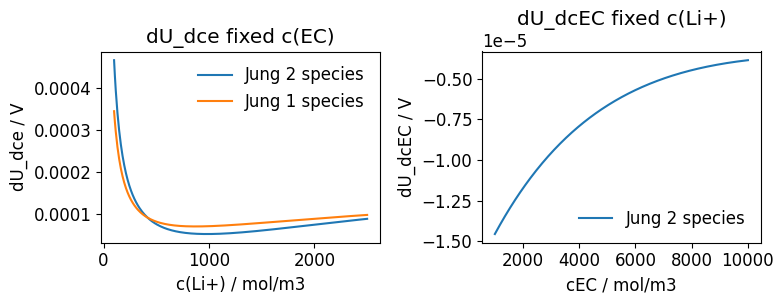

In [124]:

fig, axs = plt.subplots(1,2, figsize=(8,3.2),tight_layout=True)
axs[0].plot(C_e,np.array(ddelta_U_2Species_dce_sym),"-",label="Jung 2 species")
axs[0].plot(C_e, ddelta_U_1Species_dce,"-",label="Jung 1 species")
#axs[0].plot(C_e,np.array(dLJP_dce_Nyman),"-",label="Nyman 2 species")
#axs[0].plot(C_e,np.array(ddelta_U_2Species_dce_np),"-",label="Jung 2 species RL")

#axs[0].plot(C_e,np.array(ddelta_U_2Species_dce_sym_manual),"-.",label="Jung 2 species np")

#axs[1].plot(C_EC,np.array(dLJP_dcEC_Nyman),'-',label="Nyman 2 species")
#axs[1].plot(C_EC,np.array(ddelta_U_2Species_dco_np),"-",label="Jung 2 species RL")
axs[1].plot(C_EC,np.array(ddelta_U_2Species_dco_sym),"-",label="Jung 2 species")
#axs[1].plot(C_EC,np.array(ddelta_U_2Species_dco_sym_manual),"-.",label="Jung 2 species np")
for i in range(2): 
    axs[i].legend(loc='best',frameon=False)  
# axs[0].set_title("c(EMC) in M")
# axs[1].set_title("c_tot in M")
# plt.savefig(Path_taeho+"dU_dce and dU_dco.png", dpi=600)

axs[0].set_ylabel("dU_dce / V")
axs[0].set_title("dU_dce fixed c(EC)")
axs[0].set_xlabel("c(Li+) / mol/m3")


axs[1].set_ylabel("dU_dcEC / V")
axs[1].set_title("dU_dcEC fixed c(Li+)")
axs[1].set_xlabel("cEC / mol/m3")

In [103]:
print(
dLJP_Two_Species_dce_Jung2023(500,8000),
dLJP_Two_Species_dco_Jung2023(500,8000),
#dLJP_Two_Species_dce_r.subs({x:500,y:8e3})
)

0.00021992866815236933 -2.4183124958604914e-06


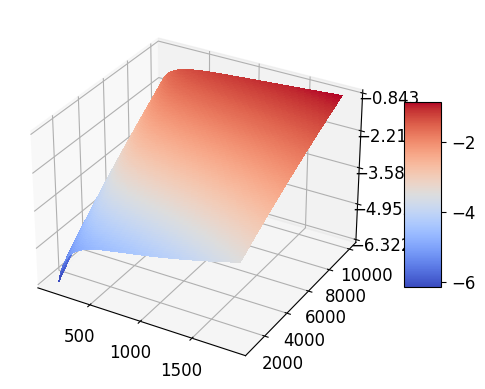

In [29]:
Y_e = np.linspace(1E-3,0.15,100).tolist(); 
Y_o = np.linspace(1E-3,0.80,100).tolist(); 
Y_o, Y_e = np.meshgrid(Y_o, Y_e)
delta_U = LJP_Two_Species(Y_o,Y_e)

C_e = np.linspace(100,1875,100).tolist(); # 
C_o = np.linspace(1e3,1e4,100).tolist(); # C_EC = np.linspace(1E3,1E4,300).tolist(); 
C_e,C_o  = np.meshgrid(C_e,C_o)

ddelta_U_dce = dLJP_Two_Species_dce_Jung2023(C_e,C_o)
ddelta_U_dco = dLJP_Two_Species_dco_Jung2023(C_e,C_o)
ddelta_U_dco_1spe = dLJP_Two_Species_dco_Jung2023(1e3,C_o)
fs=12
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# Plot the surface.
surf = ax.plot_surface(
    C_e,C_o, ddelta_U_dce,
    rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=1, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-250,50)
ax.zaxis.set_major_locator(LinearLocator(5))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:1.f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

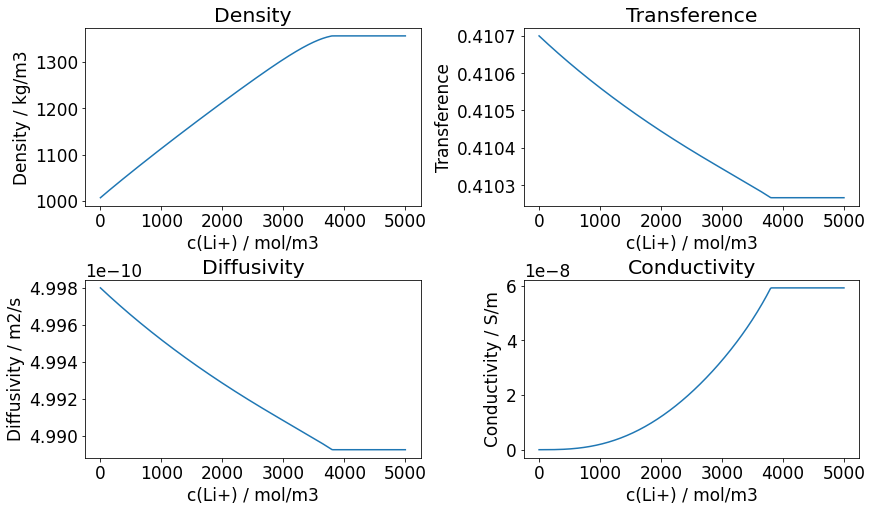

In [7]:

fs=17
font = {'family' : 'DejaVu Sans',
        'size'   : fs}
mpl.rc('font', **font)
C_e = np.linspace(1, 5000, 300).tolist(); c_EC = 6250; T=298.75
Rho = []; Diff = []; T_0plus=[]; Cond = [];
for c_e in C_e:
    Rho.append(Density_Andrew_ACS(c_e,c_EC, T))
    Diff.append(Diff_Andrew_ACS(c_e,c_EC, T))
    T_0plus.append(t_0plus_Andrew_ACS(c_e,c_EC, T))
    Cond.append(Cond_Andrew_ACS(c_e,c_EC, T))

fig, ax = plt.subplots(2,2,figsize=(12, 7), layout='constrained')
ax[0,0].plot(C_e,Rho,label='Coff=100')
ax[0,1].plot(C_e,T_0plus,label='Coff=500')
ax[1,0].plot(C_e,Diff,label='Coff=700')
ax[1,1].plot(C_e,Cond,label='Coff=1000')
ax[0,0].set_ylabel("Density / kg/m3")
ax[0,1].set_ylabel("Transference")
ax[1,0].set_ylabel("Diffusivity / m2/s")
ax[1,1].set_ylabel("Conductivity / S/m")
ax[0,0].set_title("Density")
ax[0,1].set_title("Transference")
ax[1,0].set_title("Diffusivity")
ax[1,1].set_title("Conductivity")

for i in range(0,2):
    for j in range(0,2):
        ax[i,j].set_xlabel("c(Li+) / mol/m3")
    # 